In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import classifiers
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
# Defining the dataset directory
dataset_dir = "/Users/shrikantyalakki/Documents/PES/Sem-IV/Projects/Credit-Risk-Analysis/Data"

In [3]:
application_train = pd.read_csv(f"{dataset_dir}/application_train_final_Without_Null_value_for_Model.csv")

In [9]:
# -------------------
# Define base models
# -------------------
base_models = {
    'lightgbm': LGBMClassifier(random_state=42, n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ada': AdaBoostClassifier(random_state=42),
    'logreg_l2': LogisticRegression(penalty='l2', random_state=42, max_iter=500, n_jobs=-1),
    'lr': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1, solver='saga'),
    'knn': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, n_jobs=-1),
    'dt': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=500, min_samples_split=50, min_samples_leaf=50),
}

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
# 2. Prepare features/target, drop SK_ID_CURR
X = application_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = application_train['TARGET']

In [14]:
# 3. Train-test split (stratify for imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [15]:
# 4. SMOTE - For balancing the classes
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [20]:
X_train.shape, y_train.shape, X_res.shape, y_res.shape

((246008, 244), (246008,), (452296, 244), (452296,))

In [23]:
print("Original class distribution in training set:")
print(y_train.value_counts())
print("Resampled class distribution in training set:")
y_res.value_counts()

Original class distribution in training set:
TARGET
0    226148
1     19860
Name: count, dtype: int64
Resampled class distribution in training set:


TARGET
0    226148
1    226148
Name: count, dtype: int64

In [17]:
# 5. Base models
base_models = {
    'lightgbm':  LGBMClassifier(random_state=42, n_jobs=-1),
    'rf':        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ada':       AdaBoostClassifier(random_state=42),
    'logreg_l2': LogisticRegression(penalty='l2', random_state=42, max_iter=500, n_jobs=-1),
    'lr':        LogisticRegression(max_iter=500, random_state=42, n_jobs=-1, solver='saga'),
    'knn':       KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1),
    'dt':        DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=500, min_samples_split=50, min_samples_leaf=50),
}

In [18]:
# 6. Hyperparameter grids (example for each, tailor as desired)
param_grids = {
    'lightgbm': {
        'n_estimators': [100, 200, 300], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2],
    },
    'rf': {
        'n_estimators': [100, 200], 'max_depth': [None, 10, 30], 'min_samples_split': [2, 10],
    },
    'ada': {
        'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0],
    },
    'logreg_l2': {
        'C': [0.01, 0.1, 1, 10],
    },
    'lr': {
        'C': [0.01, 0.1, 1, 10],
    },
    'knn': {
        'n_neighbors': [3, 5, 11], 'weights': ['uniform', 'distance'],
    },
    'dt': {
        'max_depth': [10, 30, 100, 500], 'min_samples_split': [2, 10, 50],
    },
}

In [25]:
# 7. Hyperparameter optimization
best_params = {}
best_scores = {}
fitted_models = {}
for name, model in base_models.items():
    print(f"Optimizing {name}...")
    grid = param_grids[name]
    search = RandomizedSearchCV(
        model, param_distributions=grid, n_iter=10, scoring='f1',
        cv=3, n_jobs=-1, random_state=42, verbose=0
    )
    search.fit(X_res, y_res)
    best_params[name] = search.best_params_
    best_scores[name] = search.best_score_
    print(f"Best F1: {search.best_score_:.4f} | Best Params: {search.best_params_}")
    
    # Training model on full balanced set with best params
    model.set_params(**search.best_params_)
    model.fit(X_res, y_res)
    fitted_models[name] = model

Optimizing lightgbm...
[LightGBM] [Info] Number of positive: 150765, number of negative: 150765
[LightGBM] [Info] Number of positive: 150765, number of negative: 150765
[LightGBM] [Info] Number of positive: 150765, number of negative: 150765
[LightGBM] [Info] Number of positive: 150766, number of negative: 150765
[LightGBM] [Info] Number of positive: 150765, number of negative: 150765
[LightGBM] [Info] Number of positive: 150765, number of negative: 150766
[LightGBM] [Info] Number of positive: 150766, number of negative: 150765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.430446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48030
[LightGBM] [Info] Number of data points in the train set: 301530, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of pos

In [27]:
# 8. Store best hyperparameters
results_df = pd.DataFrame.from_dict(best_params, orient='index')
results_df['best_f1_cv'] = pd.Series(best_scores)
results_df

,n_estimators,max_depth,learning_rate,min_samples_split,C,weights,n_neighbors,best_f1_cv
lightgbm,200.0,6.0,0.1,NaN,NaN,NaN,NaN,0.945724
rf,200.0,NaN,NaN,2.0,NaN,NaN,NaN,0.944035
ada,200.0,NaN,1.0,NaN,NaN,NaN,NaN,0.931512
dt,NaN,500.0,NaN,10.0,NaN,NaN,NaN,0.898180
logreg_l2,NaN,NaN,NaN,NaN,0.10,NaN,NaN,0.566589
lr,NaN,NaN,NaN,NaN,0.01,NaN,NaN,0.204075
knn,NaN,NaN,NaN,NaN,NaN,distance,3.0,0.870937


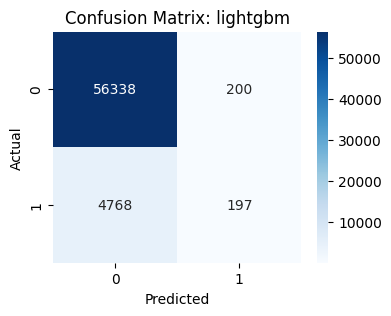

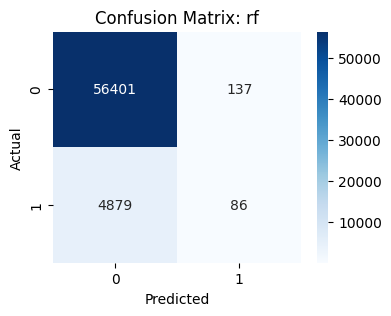

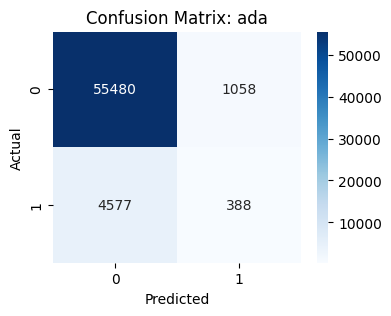

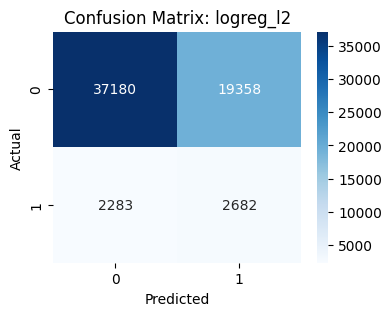

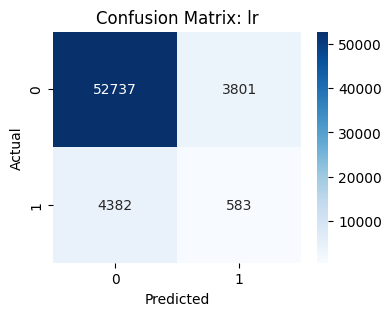

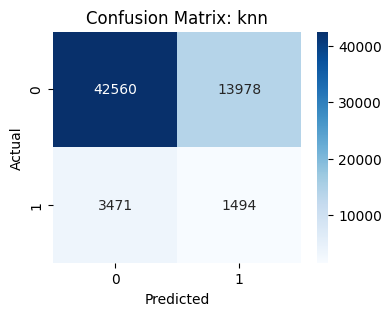

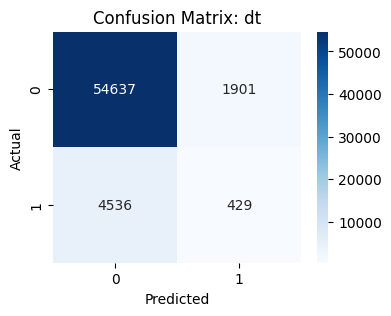

In [31]:
# 9. Evaluate models on hold-out (unbalanced) test set, metrics DataFrame and confusion heatmap
metrics_dict = {
    'model': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1_score': []
}

for name, model in fitted_models.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    metrics_dict['model'].append(name)
    metrics_dict['accuracy'].append(acc)
    metrics_dict['recall'].append(rec)
    metrics_dict['precision'].append(prec)
    metrics_dict['f1_score'].append(f1)
    
    # Confusion matrix plot
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [29]:
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,model,accuracy,recall,precision,f1_score
0,lightgbm,0.919223,0.039678,0.496222,0.073480
1,rf,0.918443,0.017321,0.385650,0.033153
2,ada,0.908378,0.078147,0.268326,0.121042
3,logreg_l2,0.648131,0.540181,0.121688,0.198630
4,lr,0.866950,0.117422,0.132984,0.124719
5,knn,0.716290,0.300906,0.096562,0.146205
6,dt,0.895338,0.086405,0.184120,0.117615
